In [1]:
# Imports
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from scipy.signal import welch, spectrogram
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Configuration
FILES = {
    'OFF': 'Motor_OFF.xlsx',
    'ON': 'Motor_ON.xlsx',
    'NO_FAN': 'Motor_NO_FAN.xlsx'
}
LABEL_MAP = {'OFF':0, 'ON':1, 'NO_FAN':2}
WINDOW_SIZE = 256 # samples per window
STEP = 128 # overlap step (50%)
DEFAULT_FS = 1000.0

# Seed
RNG = 42
np.random.seed(RNG)
tf.random.set_seed(RNG)

In [5]:
# Load files into clean DataFrames
def load_and_clean(filepath):
    df = pd.read_excel(filepath, engine='openpyxl')
    
    # Normalize column names
    df.columns = [str(c).strip() for c in df.columns]
    lowered = [c.lower() for c in df.columns]
    
    # Find timestamp if present
    ts_col = None
    for cand in ['timestamp','time','t','date','datetime']:
        if cand in lowered:
            ts_col = df.columns[lowered.index(cand)]
            break
    
    # Map sensor columns (accept variety of names)
    mapping = {}
    # accelerometer
    for name, target in [('ax','Ax'),('ay','Ay'),('az','Az'),('gx','Gx'),('gy','Gy'),('gz','Gz')]:
        if name in lowered:
            mapping[df.columns[lowered.index(name)]] = target
    
    # fallback: if mapping incomplete, pick first 6 numeric columns
    if len(mapping) < 6:
        numeric = df.select_dtypes(include=[np.number]).columns.tolist()
        
        # if timestamp present among numeric, remove it
        if ts_col in numeric:
            numeric = [c for c in numeric if c != ts_col]
        if len(numeric) >= 6:
            # assign first 6 numeric columns as Ax..Gz
            targets = ['Ax','Ay','Az','Gx','Gy','Gz']
            mapping = {numeric[i]: targets[i] for i in range(6)}
        else:
            raise ValueError(f"Cannot find 6 numeric sensor columns in {filepath}. Columns: {df.columns.tolist()}")
    
    # Rename
    df = df.rename(columns=mapping)
    
    # Ensure all expected columns present
    expected = ['Ax','Ay','Az','Gx','Gy','Gz']
    
    for c in expected:
        if c not in df.columns:
            raise ValueError(f"Missing column {c} in file {filepath}")
    
    # Handle timestamp
    if ts_col:
        df = df.rename(columns={ts_col: 'timestamp'})
        try:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        except Exception:
            # If timestamp numeric, treat as seconds/numeric index
            pass
    else:
        # create timestamp index if not available
        df['timestamp'] = np.arange(len(df))
    # reorder columns
    cols = ['timestamp'] + expected
    return df.loc[:, cols]

# Load all dataframes
data_dfs = {}
for label, path in FILES.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file {path} in current dir")
    df = load_and_clean(path)
    data_dfs[label] = df
    print(f"Loaded {label}: {df.shape}")

# Quick preview
for label, df in data_dfs.items():
    display(df.head())

Loaded OFF: (9000, 7)
Loaded ON: (9000, 7)
Loaded NO_FAN: (9000, 7)


,timestamp,Ax,Ay,Az,Gx,Gy,Gz
0,2025-09-25 11:30:49,0.028792,0.081984,0.999424,-0.8050,-0.14,-0.3850
1,2025-09-25 11:30:49,0.028792,0.081984,0.999424,-0.8050,-0.14,-0.3850
2,2025-09-25 11:30:49,0.028792,0.081984,0.999424,-0.8050,-0.14,-0.3850
3,2025-09-25 11:30:49,0.025132,0.084424,0.999668,-0.7525,-0.21,-0.4025
4,2025-09-25 11:30:49,0.025132,0.084424,0.999668,-0.7525,-0.21,-0.4025


,timestamp,Ax,Ay,Az,Gx,Gy,Gz
0,2025-09-25 11:46:10,0.100284,-0.21106,0.773724,11.41,-3.2025,-0.035
1,2025-09-25 11:46:10,0.100284,-0.21106,0.773724,11.41,-3.2025,-0.035
2,2025-09-25 11:46:10,0.100284,-0.21106,0.773724,11.41,-3.2025,-0.035
3,2025-09-25 11:46:10,0.100284,-0.21106,0.773724,11.41,-3.2025,-0.035
4,2025-09-25 11:46:10,0.100284,-0.21106,0.773724,11.41,-3.2025,-0.035


,timestamp,Ax,Ay,Az,Gx,Gy,Gz
0,2025-09-25 12:03:27,0.044164,0.152256,0.646844,-0.665,-5.8100,3.2550
1,2025-09-25 12:03:27,0.044164,0.152256,0.646844,-0.665,-5.8100,3.2550
2,2025-09-25 12:03:27,0.044164,0.152256,0.646844,-0.665,-5.8100,3.2550
3,2025-09-25 12:03:27,0.046848,0.206912,1.039684,-6.685,16.6775,-3.1325
4,2025-09-25 12:03:27,0.046848,0.206912,1.039684,-6.685,16.6775,-3.1325


In [7]:
# Infer sampling frequency (fs) if timestamp monotonic
def infer_fs(df):
    try:
        ts = pd.to_datetime(df['timestamp'])
        dt = (ts - ts.shift(1)).dropna().dt.total_seconds().values
        if len(dt) == 0:
            return DEFAULT_FS
        median_dt = np.median(dt)
        if median_dt <= 0:
            return DEFAULT_FS
        return 1.0 / median_dt
    except Exception:
        return DEFAULT_FS

fs_map = {}
for label, df in data_dfs.items():
    fs_map[label] = infer_fs(df)
    print(f"{label} inferred fs = {fs_map[label]:.3f} Hz")

# Use a single fs (if fairly equal) or choose one manually
FS = np.median(list(fs_map.values()))
print("Using FS =", FS)

OFF inferred fs = 1000.000 Hz
ON inferred fs = 1000.000 Hz
NO_FAN inferred fs = 1000.000 Hz
Using FS = 1000.0


## EDA

In [15]:
# EDA functions (separate accel vs gyro) ----
def plot_time_series(df, label, Nplot=2000):
    """Plot time domain signals separately for accel and gyro."""
    n = min(len(df), Nplot)
    t = np.arange(n) / FS
    fig, axes = plt.subplots(2,3, figsize=(14,6))
    axs = axes.flatten()
    for i, ch in enumerate(['Ax','Ay','Az','Gx','Gy','Gz']):
        ax = axs[i]
        ax.plot(t, df[ch].values[:n])
        ax.set_title(f"{label} - {ch}")
        ax.set_xlabel("time (s)")
    plt.tight_layout()
    plt.show()

def print_basic_stats(df, label):
    accel = df[['Ax','Ay','Az']].values
    gyro = df[['Gx','Gy','Gz']].values
    stats = {
        'label': label,
        'accel_mean': np.round(accel.mean(axis=0),5).tolist(),
        'accel_std': np.round(accel.std(axis=0),5).tolist(),
        'accel_rms': np.round(np.sqrt(np.mean(accel**2, axis=0)),5).tolist(),
        'gyro_mean': np.round(gyro.mean(axis=0),5).tolist(),
        'gyro_std': np.round(gyro.std(axis=0),5).tolist(),
        'gyro_rms': np.round(np.sqrt(np.mean(gyro**2, axis=0)),5).tolist()
    }
    print(pd.DataFrame([stats]).T)

def plot_histograms(df, label):
    fig, axes = plt.subplots(2,3, figsize=(12,6))
    axes = axes.flatten()
    for i, ch in enumerate(['Ax','Ay','Az','Gx','Gy','Gz']):
        sns.histplot(df[ch], ax=axes[i], kde=True, stat='density', bins=60)
        axes[i].set_title(f"{label} - {ch}")
    plt.tight_layout()
    plt.show()

def plot_psd(df, label, nperseg=512):
    """Plot Welch PSD for accel and gyro channels."""
    fig = plt.figure(figsize=(10,6))
    for i, ch in enumerate(['Ax','Ay','Az','Gx','Gy','Gz']):
        f, Pxx = welch(df[ch].values, fs=FS, nperseg=nperseg)
        plt.semilogy(f, Pxx, label=ch)
    plt.title(f"{label} - Welch PSD (all channels)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.legend()
    plt.show()

def plot_spectrogram(df, label, ch='Ax', nperseg=256, noverlap=128):
    f, t_spec, Sxx = spectrogram(df[ch].values, fs=FS, nperseg=nperseg, noverlap=noverlap)
    plt.figure(figsize=(10,3))
    plt.pcolormesh(t_spec, f, 10*np.log10(Sxx+1e-12), shading='gouraud')
    plt.ylabel('Freq [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f"{label} - Spectrogram ({ch})")
    plt.colorbar(label='dB')
    plt.ylim(0, FS/2)
    plt.show()

def corr_matrices(df, label):
    accel_corr = df[['Ax','Ay','Az']].corr()
    gyro_corr = df[['Gx','Gy','Gz']].corr()
    print(f"{label} - Accel corr:\n", np.round(accel_corr,3))
    print(f"{label} - Gyro corr:\n", np.round(gyro_corr,3))
    sns.heatmap(accel_corr, annot=True); plt.title(f"{label} Accel Corr"); plt.show()
    sns.heatmap(gyro_corr, annot=True); plt.title(f"{label} Gyro Corr"); plt.show()


=== EDA for OFF ===

                                      0
label                               OFF
accel_mean  [0.02581, -0.3032, 0.67771]
accel_std    [0.00757, 0.51025, 0.4595]
accel_rms     [0.0269, 0.59353, 0.8188]
gyro_mean   [-0.694, -0.0999, -0.36271]
gyro_std      [0.20695, 0.167, 0.04014]
gyro_rms      [0.7242, 0.1946, 0.36493]


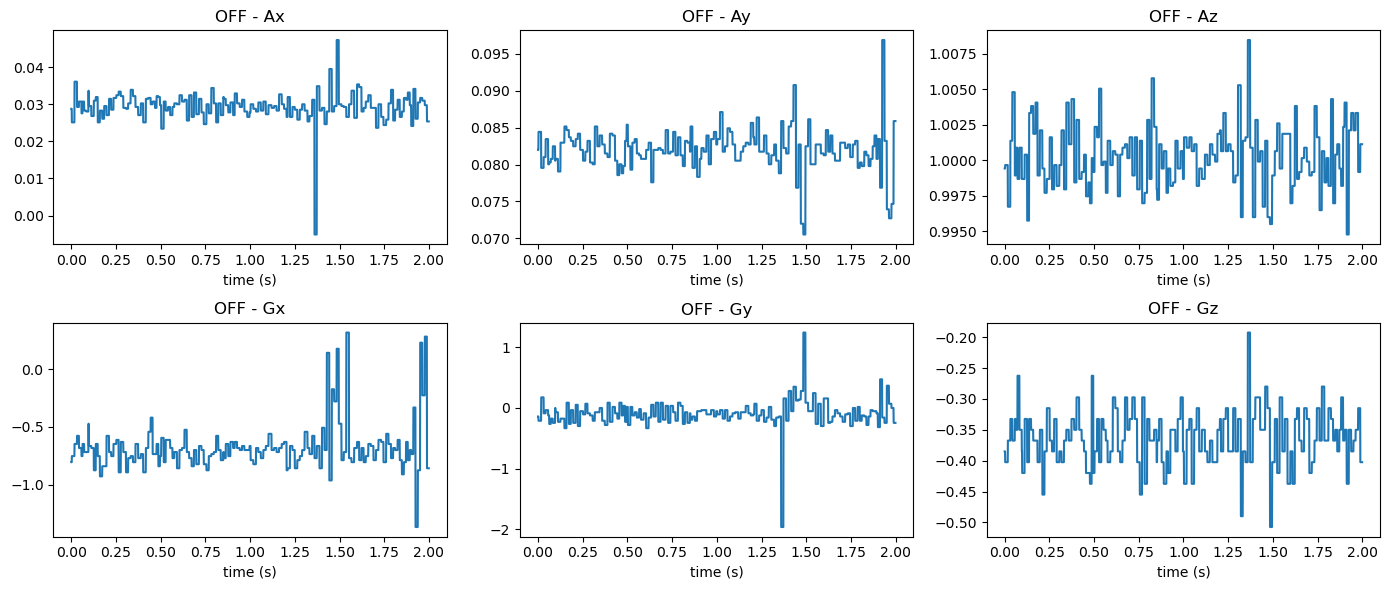

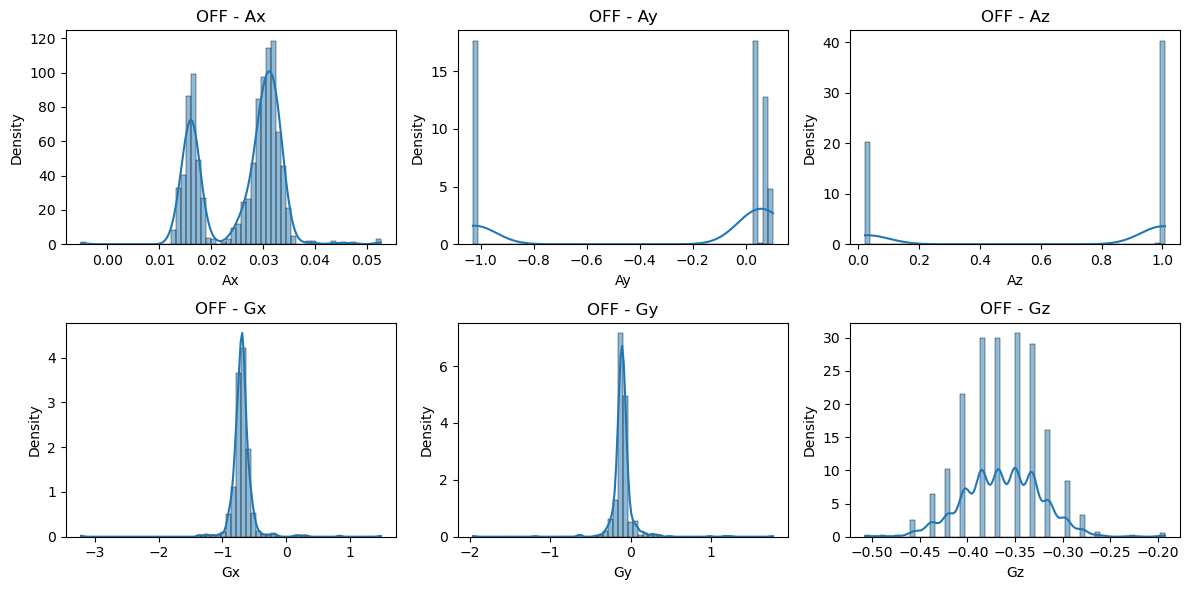

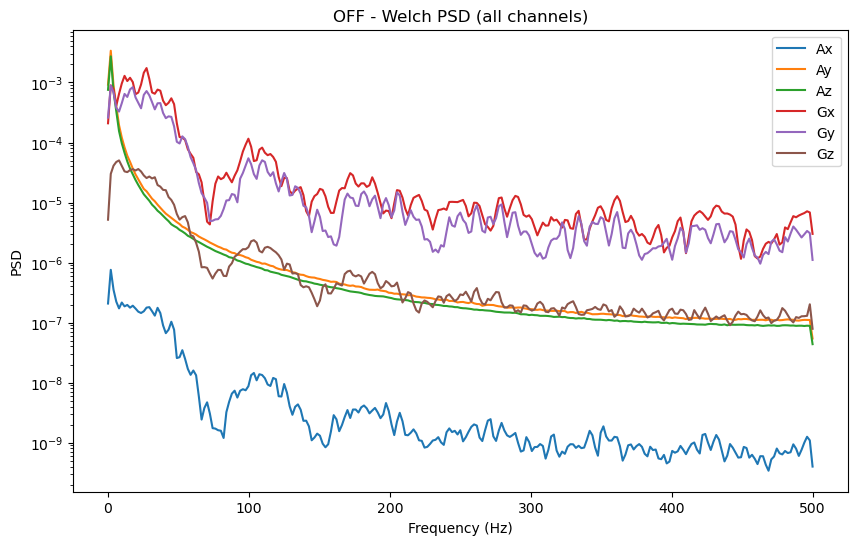

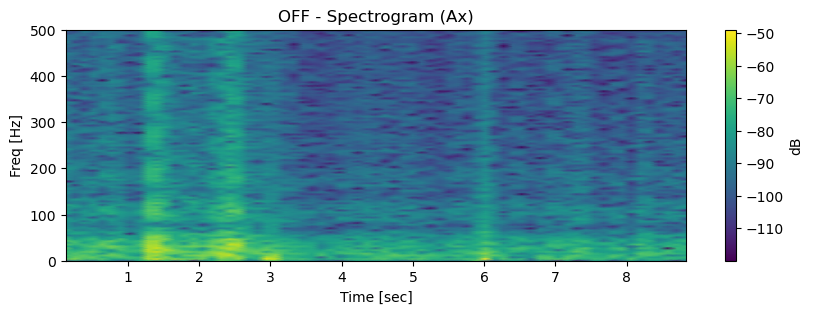

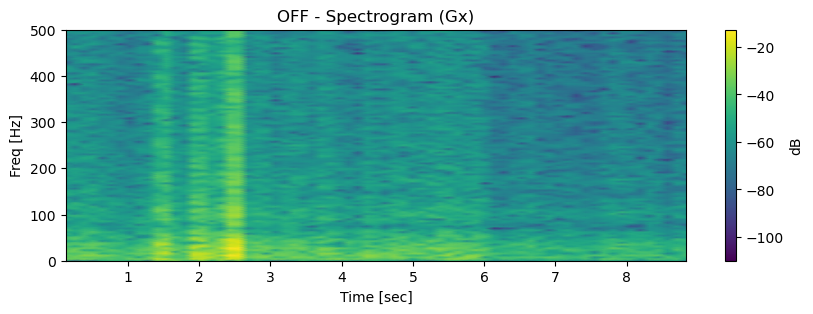

OFF - Accel corr:
        Ax     Ay     Az
Ax  1.000  0.911  0.916
Ay  0.911  1.000  0.999
Az  0.916  0.999  1.000
OFF - Gyro corr:
        Gx     Gy     Gz
Gx  1.000  0.564  0.003
Gy  0.564  1.000 -0.222
Gz  0.003 -0.222  1.000


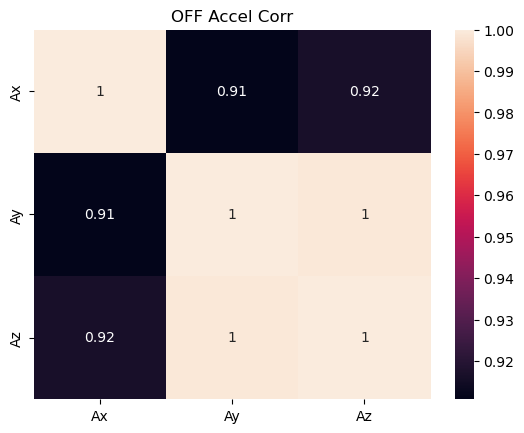

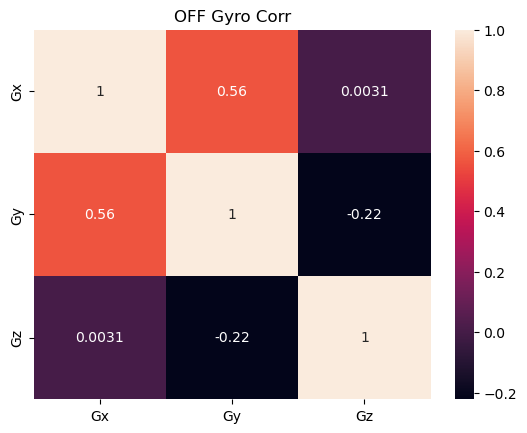


=== EDA for ON ===

                                         0
label                                   ON
accel_mean     [0.0086, -0.27347, 0.71402]
accel_std      [0.17941, 0.61636, 0.56207]
accel_rms       [0.17961, 0.6743, 0.90871]
gyro_mean   [-1.03677, -0.05278, -0.15651]
gyro_std        [11.91877, 5.25607, 7.413]
gyro_rms      [11.96378, 5.25634, 7.41465]


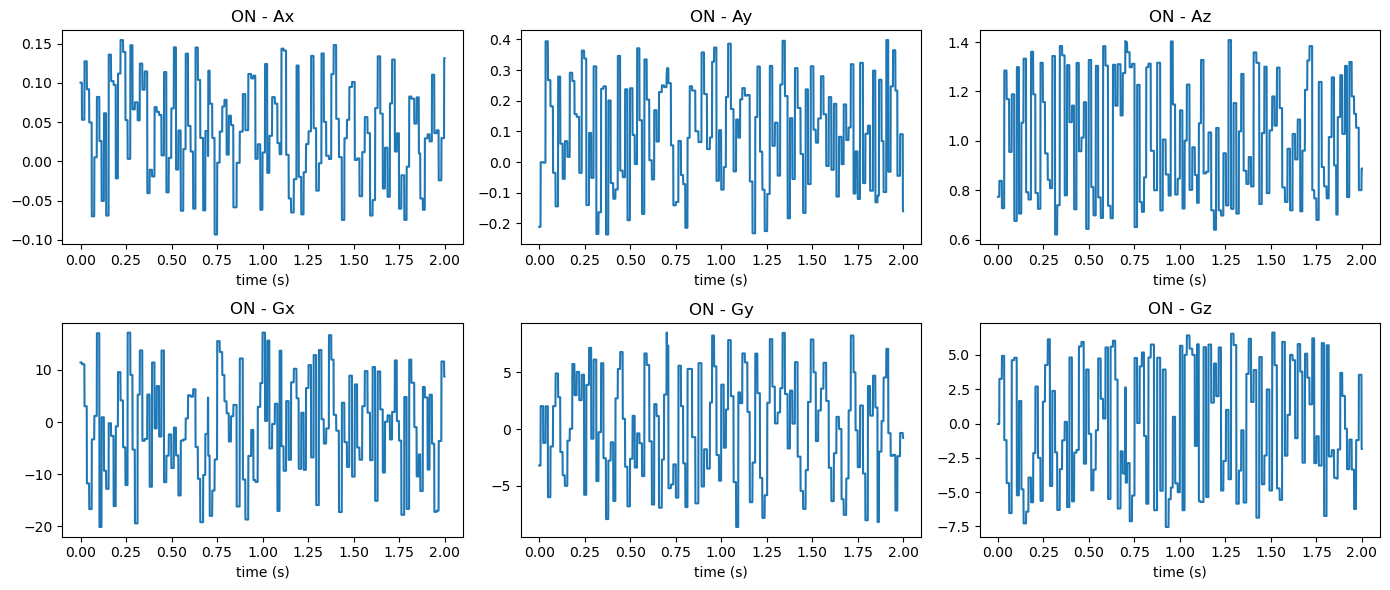

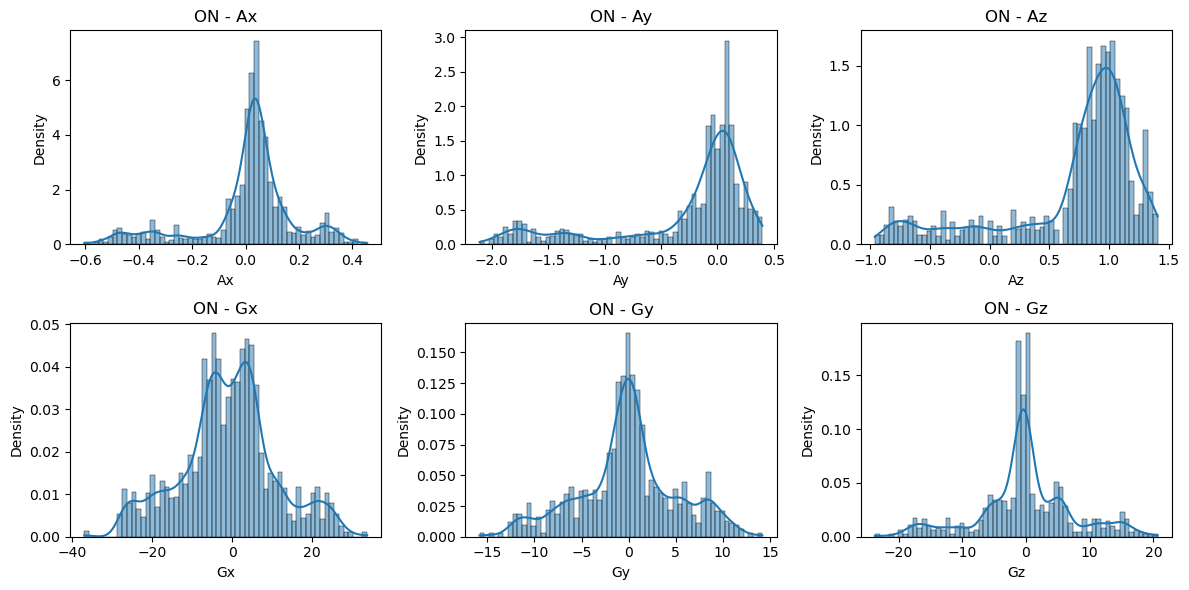

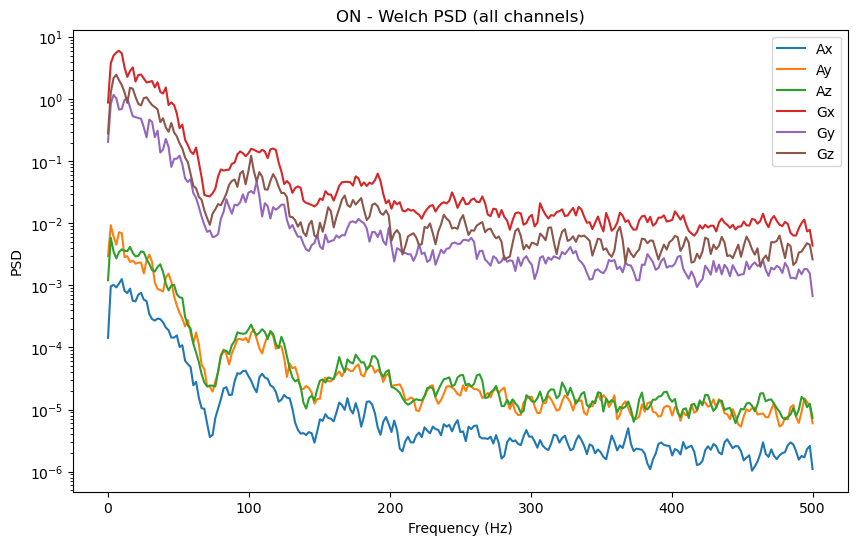

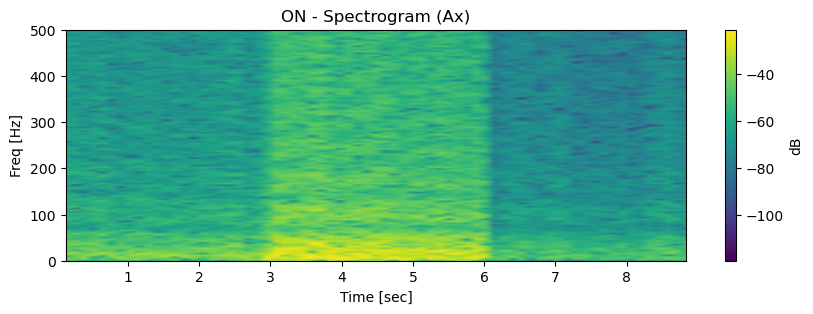

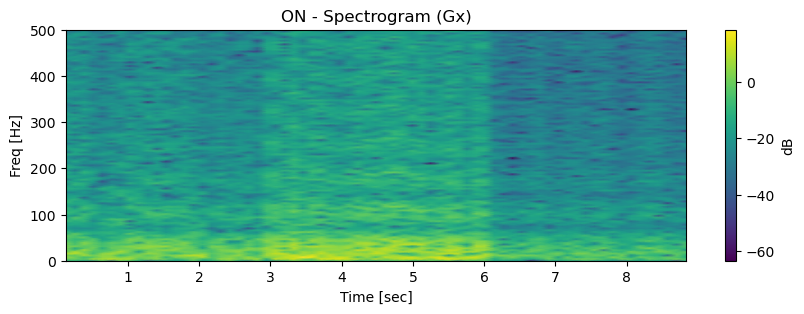

ON - Accel corr:
        Ax     Ay     Az
Ax  1.000  0.129 -0.157
Ay  0.129  1.000  0.626
Az -0.157  0.626  1.000
ON - Gyro corr:
        Gx     Gy     Gz
Gx  1.000 -0.166  0.625
Gy -0.166  1.000 -0.216
Gz  0.625 -0.216  1.000


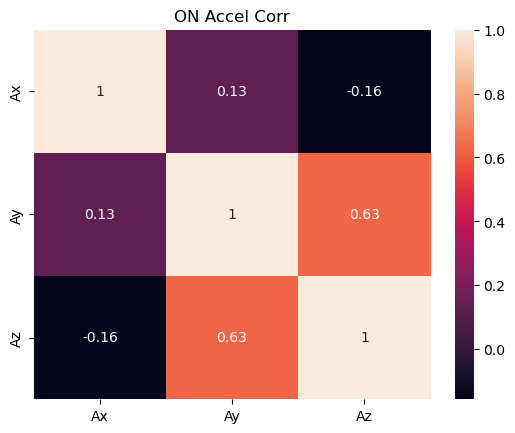

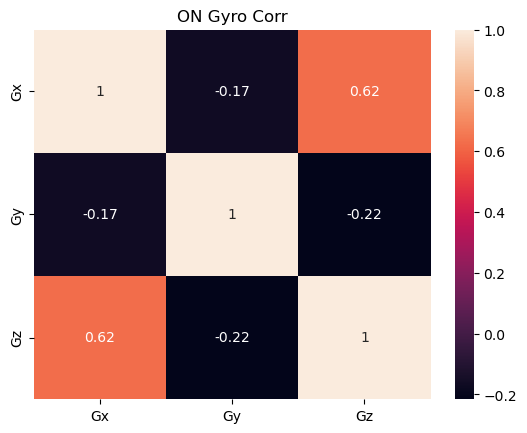


=== EDA for NO_FAN ===

                                       0
label                             NO_FAN
accel_mean  [0.00353, -0.31596, 0.69165]
accel_std    [0.23546, 0.71157, 0.61843]
accel_rms    [0.23549, 0.77856, 0.92782]
gyro_mean   [-0.12849, 0.46691, 0.30782]
gyro_std    [13.91945, 9.02041, 9.06158]
gyro_rms    [13.92005, 9.03248, 9.06681]


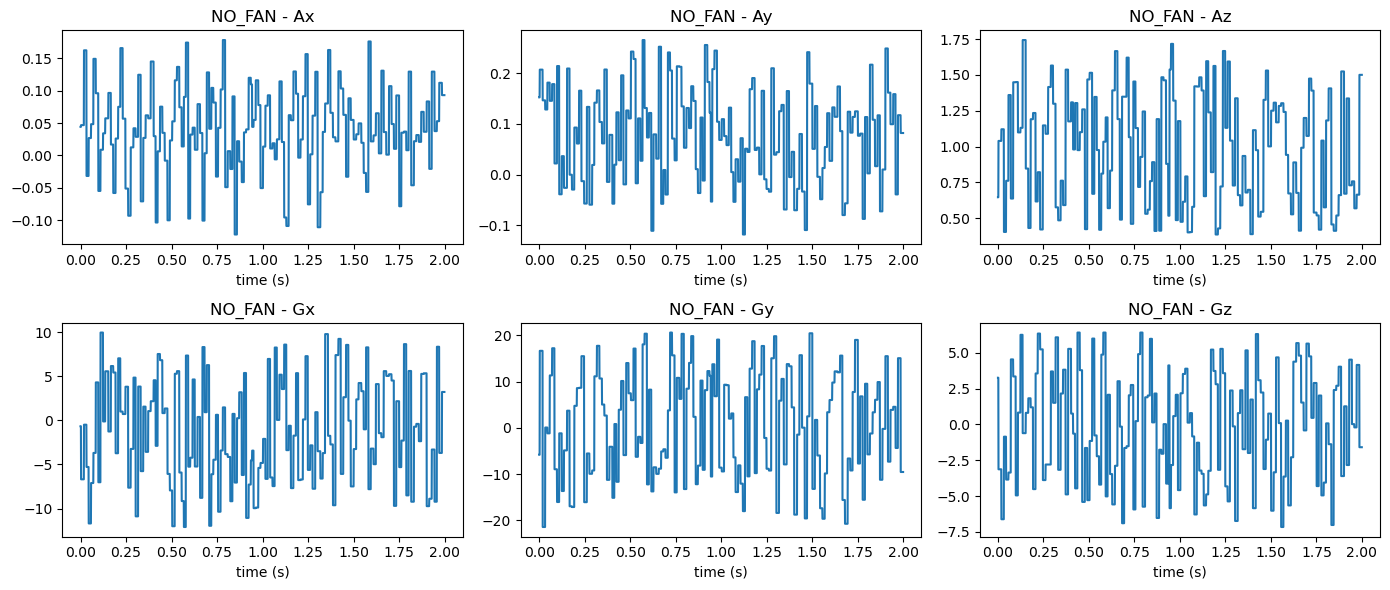

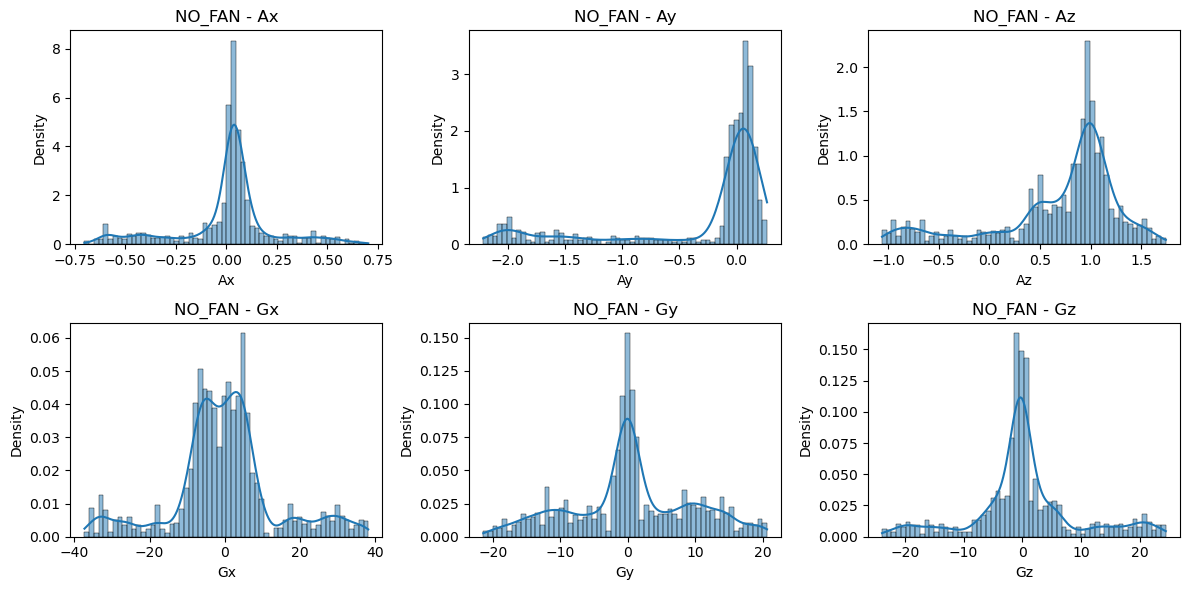

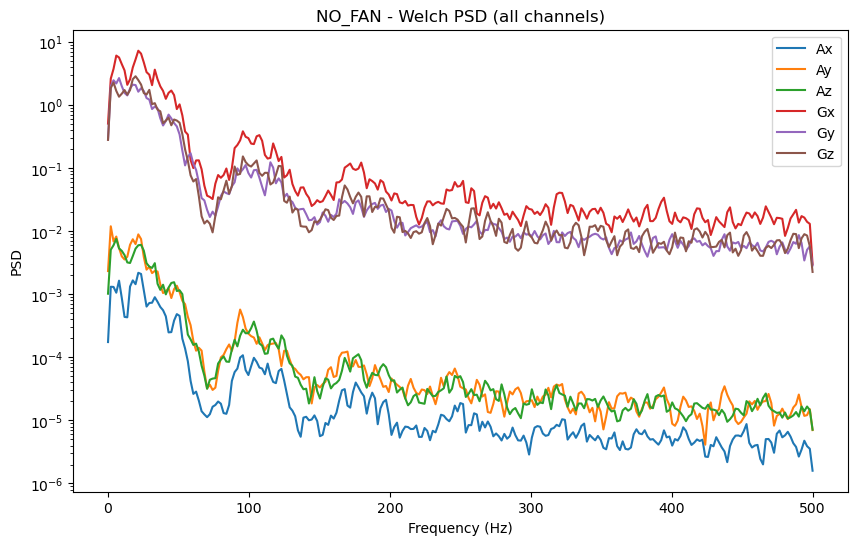

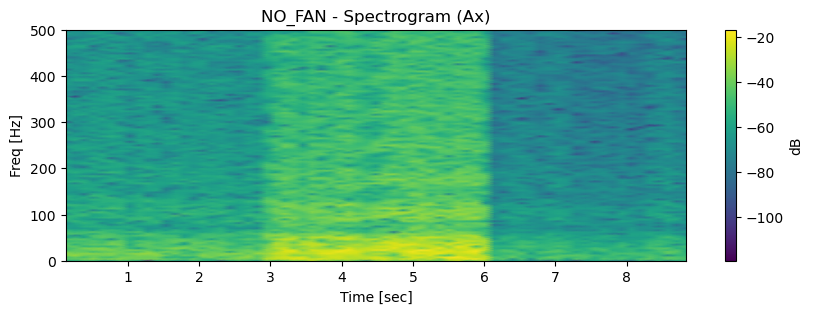

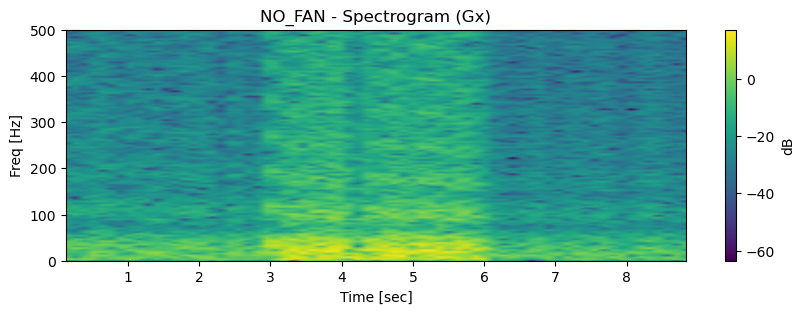

NO_FAN - Accel corr:
        Ax     Ay     Az
Ax  1.000  0.302 -0.206
Ay  0.302  1.000  0.439
Az -0.206  0.439  1.000
NO_FAN - Gyro corr:
        Gx     Gy     Gz
Gx  1.000  0.010  0.675
Gy  0.010  1.000  0.277
Gz  0.675  0.277  1.000


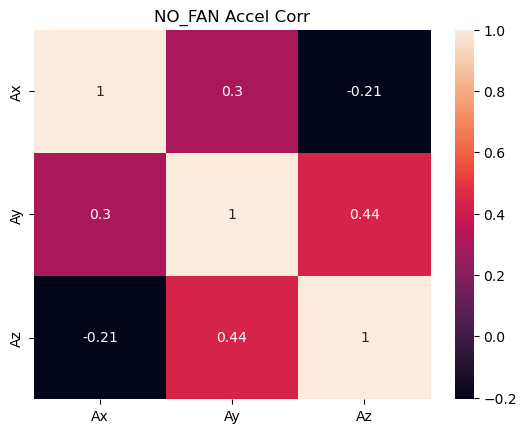

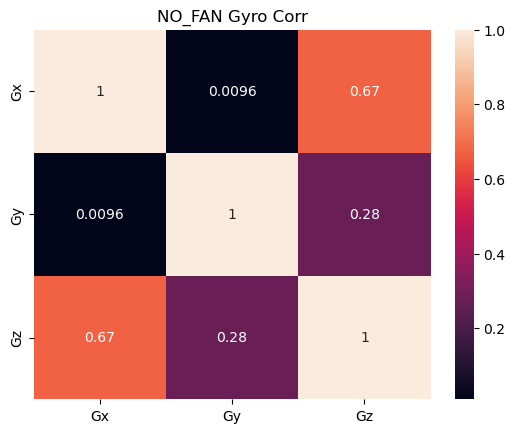

In [17]:
# Run EDA per file
for label, df in data_dfs.items():
    print("\n=== EDA for", label, "===\n")
    print_basic_stats(df, label)
    plot_time_series(df, label, Nplot=2000)
    plot_histograms(df, label)
    plot_psd(df, label)
    # spectrogram for one representative channel per sensor type
    plot_spectrogram(df, label, ch='Ax')
    plot_spectrogram(df, label, ch='Gx')
    corr_matrices(df, label)

In [19]:
# Windowing: produce time-series windows and labels
def make_windows_from_df(df, window_size=WINDOW_SIZE, step=STEP):
    arr = df[['Ax','Ay','Az','Gx','Gy','Gz']].to_numpy(dtype=np.float32)
    n = arr.shape[0]
    windows = []
    for start in range(0, n - window_size + 1, step):
        w = arr[start:start+window_size]    # shape: window_size x 6
        windows.append(w)
    return np.stack(windows, axis=0)       # n_windows x window_size x 6

X_list, y_list = [], []
for label, df in data_dfs.items():
    W = make_windows_from_df(df, WINDOW_SIZE, STEP)
    X_list.append(W)
    y_list.append(np.full((W.shape[0],), LABEL_MAP[label], dtype=int))
    print(f"{label}: windows={W.shape[0]}")

X = np.concatenate(X_list, axis=0)   # total_windows x window_size x 6
y = np.concatenate(y_list, axis=0)
print("Total windows:", X.shape, "Labels distribution:", Counter(y))

OFF: windows=69
ON: windows=69
NO_FAN: windows=69
Total windows: (207, 256, 6) Labels distribution: Counter({0: 69, 1: 69, 2: 69})


In [21]:
# Shuffle then split
X, y = shuffle(X, y, random_state=RNG)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RNG)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RNG)
print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test shapes: (144, 256, 6) (31, 256, 6) (32, 256, 6)


In [23]:
# Preprocess: per-channel standardization (fit on train)
scalers = {}
for ch in range(X_train.shape[2]):
    s = StandardScaler()
    # fit on flattened time dimension
    s.fit(X_train[:,:,ch])
    # transform all splits
    X_train[:,:,ch] = s.transform(X_train[:,:,ch])
    X_val[:,:,ch] = s.transform(X_val[:,:,ch])
    X_test[:,:,ch] = s.transform(X_test[:,:,ch])
    scalers[ch] = s

In [25]:
# Feature engineering (time + spectral) for an alternate feature-based model
def extract_features_from_window(window):  # window: window_size x 6
    # Time-domain features per channel
    feats = []
    for i in range(6):
        v = window[:, i]
        feats += [v.mean(), v.std(), np.sqrt(np.mean(v**2)), v.max()-v.min(), skew(v), kurtosis(v)]
    # Spectral features: dominant frequency and spectral centroid per channel (small FFT)
    n = window.shape[0]
    freqs = np.fft.rfftfreq(n, d=1.0/FS)
    S = np.abs(np.fft.rfft(window, axis=0))  # shape freq_bins x channels
    Ssum = S.sum(axis=0, keepdims=True)
    Ssum[Ssum==0] = 1e-12
    centroid = (S * freqs[:,None]).sum(axis=0) / Ssum.squeeze()
    dom_idx = np.argmax(S, axis=0)
    dom_freq = freqs[dom_idx]
    feats += dom_freq.tolist()
    feats += centroid.tolist()
    return np.array(feats, dtype=np.float32)

In [27]:
# Compute features for all windows
X_feat = np.vstack([extract_features_from_window(w) for w in X])
print("Feature matrix shape:", X_feat.shape)

# Scale features
feat_scaler = StandardScaler()
X_feat = feat_scaler.fit_transform(X_feat)

# Split into train/val/test aligned with earlier indices
# We already shuffled and split before features; so recompute indices:
n_total = X.shape[0]
idx = np.arange(n_total)

# recompute splits using same random state so indices match
idx_train, idx_temp = train_test_split(idx, test_size=0.30, stratify=y, random_state=RNG)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.50, stratify=y[idx_temp], random_state=RNG)
Xf_train, Xf_val, Xf_test = X_feat[idx_train], X_feat[idx_val], X_feat[idx_test]
yf_train, yf_val, yf_test = y[idx_train], y[idx_val], y[idx_test]
print("Feature splits:", Xf_train.shape, Xf_val.shape, Xf_test.shape)

Feature matrix shape: (207, 48)
Feature splits: (144, 48) (31, 48) (32, 48)


In [52]:
# Data augmentation helpers (for raw windows)
def aug_jitter(window, sigma=0.01):
    return window + np.random.normal(0.0, sigma, window.shape)

def aug_scaling(window, sigma=0.05):
    factor = np.random.normal(1.0, sigma, (1, window.shape[1]))
    return window * factor

def aug_time_shift(window, max_shift_frac=0.1):
    shift = int(np.random.uniform(-max_shift_frac, max_shift_frac) * window.shape[0])
    return np.roll(window, shift, axis=0)

def augment_window(window):
    w = window.copy()
    if np.random.rand() < 0.6:
        w = aug_jitter(w, sigma=0.01)
    if np.random.rand() < 0.4:
        w = aug_scaling(w, sigma=0.05)
    if np.random.rand() < 0.3:
        w = aug_time_shift(w, max_shift_frac=0.08)
    return w

In [54]:
# Balance/oversample training set by augmenting minority classes
def balance_and_augment(X_train, y_train, target_count=None, rng_seed=42):
    np.random.seed(rng_seed)
    uniq, counts = np.unique(y_train, return_counts=True)
    counts_map = dict(zip(uniq, counts))
    if target_count is None:
        target_count = int(max(counts))  # equalize to max class count
    X_aug_list = []
    y_aug_list = []
    for cls in uniq:
        idxs = np.where(y_train == cls)[0]
        n_current = len(idxs)
        # keep existing ones
        X_aug_list.append(X_train[idxs])
        y_aug_list.append(y_train[idxs])
        # if need more, sample with replacement and augment
        if n_current < target_count:
            need = target_count - n_current
            choices = np.random.choice(idxs, size=need, replace=True)
            augmented = []
            for c in choices:
                w = X_train[c]
                w_aug = augment_window(w)
                augmented.append(w_aug)
            X_aug_list.append(np.stack(augmented, axis=0))
            y_aug_list.append(np.full((need,), cls, dtype=int))
    X_bal = np.concatenate(X_aug_list, axis=0)
    y_bal = np.concatenate(y_aug_list, axis=0)
    # shuffle
    perm = np.random.permutation(len(y_bal))
    return X_bal[perm], y_bal[perm]

print("Original train distribution:", Counter(y_train))
X_train_bal, y_train_bal = balance_and_augment(X_train, y_train, target_count=None)
print("Balanced train distribution:", Counter(y_train_bal))
print("Balanced X shape:", X_train_bal.shape)

Original train distribution: Counter({0: 48, 2: 48, 1: 48})
Balanced train distribution: Counter({2: 48, 0: 48, 1: 48})
Balanced X shape: (144, 256, 6)


In [56]:
# ---------------- Custom focal loss (works with sparse integer labels) ----------------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        # y_true: (batch,) integer labels
        # y_pred: (batch, num_classes) probabilities
        y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        p_t = tf.reduce_sum(y_true_onehot * y_pred, axis=-1)  # shape (batch,)
        epsilon = 1e-9
        p_t = tf.clip_by_value(p_t, epsilon, 1.0)
        loss = - alpha * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    return loss_fn

## MODEL

In [62]:
# Model definitions
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_hybrid_model(input_shape, num_classes, l2_reg=1e-4):
    """
    Hybrid model: SeparableConv1D blocks (with depthwise+pointwise regularizers),
    small squeeze-excite-like attention, then a small LSTM and classifier.
    """
    inp = keras.Input(shape=input_shape, name='input')   # (window_size, channels)
    x = inp

    # ---- Block 1 ----
    x = layers.SeparableConv1D(
        32, 5, padding='same', activation=None,
        depthwise_regularizer=keras.regularizers.l2(l2_reg),
        pointwise_regularizer=keras.regularizers.l2(l2_reg)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv1D(
        32, 5, padding='same', activation=None,
        depthwise_regularizer=keras.regularizers.l2(l2_reg),
        pointwise_regularizer=keras.regularizers.l2(l2_reg)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)

    # ---- Block 2 ----
    x = layers.SeparableConv1D(
        48, 3, padding='same', activation=None,
        depthwise_regularizer=keras.regularizers.l2(l2_reg),
        pointwise_regularizer=keras.regularizers.l2(l2_reg)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv1D(
        48, 3, padding='same', activation=None,
        depthwise_regularizer=keras.regularizers.l2(l2_reg),
        pointwise_regularizer=keras.regularizers.l2(l2_reg)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)

    # ---- Cheap squeeze-and-excite style attention ----
    # obtain channel dimension safely
    channels = tf.keras.backend.int_shape(x)[-1]
    se = layers.GlobalAveragePooling1D()(x)                      # (batch, channels)
    se = layers.Dense(max(8, channels // 4), activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)       # gating per-channel
    se = layers.Reshape((1, channels))(se)                      # (batch, 1, channels)
    x = layers.Multiply()([x, se])                              # broadcast multiply

    # ---- Small LSTM to capture longer dependencies ----
    x = layers.LSTM(64, return_sequences=False)(x)

    # ---- Classifier ----
    x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inp, outputs=out, name='hybrid_separable_lstm')
    return model

# --- Create and compile the model (with focal loss from your earlier code) ---
input_shape = X_train.shape[1:]   # e.g. (256, 6)
num_classes = len(np.unique(y_train))

model = build_hybrid_model(input_shape, num_classes)
model.summary()
print("Total params:", model.count_params())

# focal_loss function assumed defined earlier; reuse it
loss_fn = focal_loss(gamma=2.0, alpha=0.25)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
]


Model: "hybrid_separable_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 6)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_1  │ (None, 256, 32)   │        254 │ input[0][0]       │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_2  │ (None, 256, 32)   │      1,216 │ activation[0][0]  │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 128, 32)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_3  │ (None, 128, 48)   │      1,680 │ max_pooling1d_5[… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 48)   │        192 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 48)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_4  │ (None, 128, 48)   │      2,496 │ activation_2[0][… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 48)   │        192 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 48)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 64, 48)    │          0 │ activation_3[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 48)        │          0 │ max_pooling1d_6[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 12)        │        588 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 40,781 (159.30 KB)

 Trainable params: 40,461 (158.05 KB)

 Non-trainable params: 320 (1.25 KB)

Total params: 40781


In [64]:
# ---------------- Train on balanced (augmented) arrays ----------------
history = model.fit(X_train_bal, y_train_bal,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=2)

# ---------------- Evaluate ----------------
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss_test:.4f}, Test acc: {acc_test:.4f}")

yhat = np.argmax(model.predict(X_test), axis=1)
print("Classification report (zero_division=0):")
print(classification_report(y_test, yhat, target_names=list(LABEL_MAP.keys()), zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, yhat))

Epoch 1/100
5/5 - 2s - 446ms/step - accuracy: 0.3819 - loss: 0.1327 - val_accuracy: 0.3226 - val_loss: 0.1420 - learning_rate: 0.0010
Epoch 2/100
5/5 - 0s - 27ms/step - accuracy: 0.5486 - loss: 0.1163 - val_accuracy: 0.5806 - val_loss: 0.1418 - learning_rate: 0.0010
Epoch 3/100
5/5 - 0s - 27ms/step - accuracy: 0.6181 - loss: 0.1051 - val_accuracy: 0.3548 - val_loss: 0.1418 - learning_rate: 0.0010
Epoch 4/100
5/5 - 0s - 26ms/step - accuracy: 0.7083 - loss: 0.0942 - val_accuracy: 0.3548 - val_loss: 0.1419 - learning_rate: 0.0010
Epoch 5/100
5/5 - 0s - 26ms/step - accuracy: 0.7292 - loss: 0.0882 - val_accuracy: 0.3548 - val_loss: 0.1419 - learning_rate: 0.0010
Epoch 6/100
5/5 - 0s - 26ms/step - accuracy: 0.7986 - loss: 0.0781 - val_accuracy: 0.3548 - val_loss: 0.1417 - learning_rate: 0.0010
Epoch 7/100
5/5 - 0s - 27ms/step - accuracy: 0.8056 - loss: 0.0710 - val_accuracy: 0.3548 - val_loss: 0.1413 - learning_rate: 0.0010
Epoch 8/100
5/5 - 0s - 27ms/step - accuracy: 0.8264 - loss: 0.0629 -